In [1]:
import pandas as pd
import numpy as np
import plotly as px
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pickle
from colorama import Fore, Back, Style
import json
import os
import matplotlib.colors as mcolors

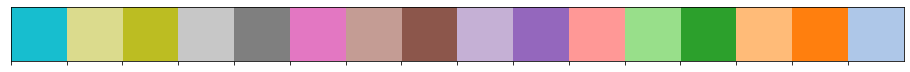

In [2]:
colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)
sns.set_style("darkgrid")

# Importation

In [3]:
df = pd.read_pickle('df_clean.pickle')

### Généralités

In [4]:
df.head()

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,ANNEEDEPLANTATION,COLLECTIVITE,LATITUDE,LONGITUDE,SUM_COORDINATE
12,Arbre de voirie,Bd Esplan Autoroute A 48,2,Pinus,nigra,Arbre adulte,1970.0,Ville de Grenoble,45.194803,5.716918,50.911721
15,Arbre de voirie,Bd Esplan Autoroute A 48,2,Pinus,nigra,Arbre adulte,1970.0,Ville de Grenoble,45.195170,5.716655,50.911825
16,Arbre de voirie,Bd Esplan Autoroute A 48,2,Populus,alba,Arbre adulte,1970.0,Ville de Grenoble,45.195246,5.716624,50.911870
18,Arbre d'espaces ouverts,Ch Gordes Ouest conservatoire,4,Diospyros,kaki,Arbre jeune,2018.0,Ville de Grenoble,45.173315,5.734082,50.907397
22,Arbre de voirie,R Frederico Garcia Lorca park,5,NaN,NaN,NaN,2016.0,Grenoble Alpes Métropole,45.171728,5.734265,50.905994


In [5]:
df.columns

Index(['SOUS_CATEGORIE_DESC', 'CODE_PARENT_DESC', 'ADR_SECTEUR', 'GENRE_BOTA',
       'ESPECE', 'STADEDEDEVELOPPEMENT', 'ANNEEDEPLANTATION', 'COLLECTIVITE',
       'LATITUDE', 'LONGITUDE', 'SUM_COORDINATE'],
      dtype='object')

In [6]:
df.describe()

,ADR_SECTEUR,ANNEEDEPLANTATION,LATITUDE,LONGITUDE,SUM_COORDINATE
count,30180.000000,30180.000000,30180.000000,30180.000000,30180.000000
mean,3.852584,1989.384427,45.177150,5.727585,50.904734
std,1.702122,17.372641,0.011917,0.012762,0.017911
min,1.000000,1900.000000,45.151572,5.697915,50.863142
25%,2.000000,1975.000000,45.166272,5.717804,50.893043
50%,4.000000,1985.000000,45.175801,5.729950,50.903998
75%,5.000000,2004.000000,45.187076,5.737493,50.917701
max,6.000000,2021.000000,45.224825,5.798704,51.023187


=> ADR_SECTEUR représente 6 secteurs. Mais n'a pas de continuité numérique logique

### Analyse des colonnes avant Pipeline

In [7]:
df["SOUS_CATEGORIE_DESC"].value_counts()

Arbre d'espaces ouverts      14979
Arbre de voirie              11515
Arbre d'enceintes fermées     2128
Bois semi naturel             1558
Name: SOUS_CATEGORIE_DESC, dtype: int64

=> Seulement 3 catégories, se prête bien au OneHot imputer

In [8]:
df["CODE_PARENT_DESC"].value_counts()

Prc Echangeurs Bastion St Roch    393
Le Bastion zone boisée            338
Cimetière St Roch                 305
Grande pelouse butte des pins     273
Prc Echangeurs Valmy Gallieni     268
                                 ... 
R du Fer à Cheval                   1
R Delacroix garage 1000 lacs        1
R Vendres                           1
Pl Claveyson                        1
R Fourrier n 2bis                   1
Name: CODE_PARENT_DESC, Length: 1451, dtype: int64

=> Description Géographique, pas forcément utile de l'ajouter aux latitudes, longitudes ou Secteur

In [9]:
df["GENRE_BOTA"].value_counts()

Acer           4984
Platanus       4450
Pinus          1932
Tilia          1736
Fraxinus       1446
               ... 
Eucalyptus        1
Sorbopyrus        1
Sciadopitys       1
Poncinos          1
Castanea          1
Name: GENRE_BOTA, Length: 118, dtype: int64

=> 118 valeurs différentes. Pas évident à numériser, le OneHot donnera beaucoup de colonne et le Ordinal n'aurait pas de sens

In [10]:
df["ESPECE"].value_counts()

acerifolia        3778
nigra             1825
pseudoplatanus    1300
betulus           1159
platanoides       1017
                  ... 
koreana              1
heterophylla         1
opalus               1
pisifera             1
strobus              1
Name: ESPECE, Length: 274, dtype: int64

=> IDEM

In [11]:
df["COLLECTIVITE"].value_counts()

Ville de Grenoble           15718
Grenoble Alpes Métropole    14462
Name: COLLECTIVITE, dtype: int64

=> Binaire. Facile pour un OneHot

=> Donne pas beaucoup d'infos

### Nouveau dataframe filtré

In [12]:
colToKeep = ['SOUS_CATEGORIE_DESC', 'ADR_SECTEUR', 'STADEDEDEVELOPPEMENT', 'ANNEEDEPLANTATION','LATITUDE', 'LONGITUDE', 'SUM_COORDINATE']

In [13]:
df_filtered = df[colToKeep]

In [14]:
df_filtered.info

<bound method DataFrame.info of            SOUS_CATEGORIE_DESC  ADR_SECTEUR STADEDEDEVELOPPEMENT  \
12             Arbre de voirie            2         Arbre adulte   
15             Arbre de voirie            2         Arbre adulte   
16             Arbre de voirie            2         Arbre adulte   
18     Arbre d'espaces ouverts            4          Arbre jeune   
22             Arbre de voirie            5                  NaN   
...                        ...          ...                  ...   
31613  Arbre d'espaces ouverts            5          Arbre jeune   
31614  Arbre d'espaces ouverts            5         Arbre adulte   
31615          Arbre de voirie            5         Arbre adulte   
31616          Arbre de voirie            5          Arbre jeune   
31617          Arbre de voirie            5          Arbre jeune   

       ANNEEDEPLANTATION   LATITUDE  LONGITUDE  SUM_COORDINATE  
12                1970.0  45.194803   5.716918       50.911721  
15                197

In [15]:
df_filtered.to_pickle('data_filtered.pickle')

### Split Train / Test dataset

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
raw_data = pd.read_pickle('data_filtered.pickle')
annees = raw_data["ANNEEDEPLANTATION"]
data = raw_data.drop(columns="ANNEEDEPLANTATION")

# Preprocessing

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [19]:
data.columns

Index(['SOUS_CATEGORIE_DESC', 'ADR_SECTEUR', 'STADEDEDEVELOPPEMENT',
       'LATITUDE', 'LONGITUDE', 'SUM_COORDINATE'],
      dtype='object')

### --> SOUS_CATEGORIE_DESC && ADR_SECTEUR

In [20]:
print("------- SOUS CATEGORIE DESC --------")
display(data["SOUS_CATEGORIE_DESC"].value_counts())
print("")
print("------------ ADR_SECTEUR -----------")
display(data["ADR_SECTEUR"].value_counts())

print("------------ Nan -------------")
display(data["SOUS_CATEGORIE_DESC"].isna().value_counts())
display(data["ADR_SECTEUR"].isna().value_counts())

------- SOUS CATEGORIE DESC --------


Arbre d'espaces ouverts      14979
Arbre de voirie              11515
Arbre d'enceintes fermées     2128
Bois semi naturel             1558
Name: SOUS_CATEGORIE_DESC, dtype: int64


------------ ADR_SECTEUR -----------


6    6836
5    6635
2    5936
3    4142
4    3717
1    2914
Name: ADR_SECTEUR, dtype: int64

------------ Nan -------------


False    30180
Name: SOUS_CATEGORIE_DESC, dtype: int64

False    30180
Name: ADR_SECTEUR, dtype: int64

=> Pas de nan donc pas besoin d'Imputer

In [21]:
oneHotColumns = ["SOUS_CATEGORIE_DESC", "ADR_SECTEUR"]

-----

In [22]:
pipeline_1 = Pipeline([
     ('onehotencoder', OneHotEncoder(sparse=False))
     ])

------

### --> STADEDEDEVELOPPEMENT

In [23]:
print("------- STADEDEDEVELOPPEMENT --------")
display(data["STADEDEDEVELOPPEMENT"].value_counts())
data["STADEDEDEVELOPPEMENT"].isna().value_counts()

------- STADEDEDEVELOPPEMENT --------


Arbre adulte          21565
Arbre jeune            6577
Arbre vieillissant      249
Name: STADEDEDEVELOPPEMENT, dtype: int64

False    28391
True      1789
Name: STADEDEDEVELOPPEMENT, dtype: int64

In [24]:
mapping = {'Arbre jeune': 1, 'Arbre adulte': 2, 'Arbre vieillissant': 3}

In [25]:
data['STADEDEDEVELOPPEMENT'] = df['STADEDEDEVELOPPEMENT'].map(mapping)
data['STADEDEDEVELOPPEMENT']

12       2.0
15       2.0
16       2.0
18       1.0
22       NaN
        ... 
31613    1.0
31614    2.0
31615    2.0
31616    1.0
31617    1.0
Name: STADEDEDEVELOPPEMENT, Length: 30180, dtype: float64

------

In [26]:
pipeline_2 = Pipeline([
    ('imputerStadeDev', SimpleImputer(strategy='constant', fill_value=0)),
    ("standartScaler", StandardScaler())
     ])

------

### Numerical value

In [27]:
data["LATITUDE"].isna().value_counts()

False    30180
Name: LATITUDE, dtype: int64

In [28]:
pipeline_3 = Pipeline([
     ('std_scaler', StandardScaler())
     ])

## FULL PIPE

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, annees, test_size=0.25, random_state=42, stratify=annees)

In [30]:
full_pipeline = ColumnTransformer([
    ("onehotencoder", pipeline_1, ["SOUS_CATEGORIE_DESC", "ADR_SECTEUR"]),
    ("imputerStadDev", pipeline_2, ["STADEDEDEVELOPPEMENT"]),
    ("standartScaler", pipeline_3, ["LATITUDE", "LONGITUDE", "SUM_COORDINATE"])
 ])

In [31]:
col = [
    "espaces ouverts", 
    "voirie", 
    "enceintes fermées", 
    "Bois semi naturel",
    "sec-1", 
    "sec-2", 
    "sec-3", 
    "sec-4", 
    "sec-5", 
    "sec-6", 
    "STADEDEDEVELOPPEMENT", 
    "LATITUDE", 
    "LONGITUDE", 
    "SUM_COORDINATE"
]

In [32]:
X_train = full_pipeline.fit_transform(X_train)
X_train=pd.DataFrame(X_train, columns=col)

In [33]:
X_train

,espaces ouverts,voirie,enceintes fermées,Bois semi naturel,sec-1,sec-2,sec-3,sec-4,sec-5,sec-6,STADEDEDEVELOPPEMENT,LATITUDE,LONGITUDE,SUM_COORDINATE
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.799727,-1.134141,-1.728452,-1.989685
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.550797,-0.666504,0.378874,-0.175064
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.550797,-0.998473,0.404888,-0.378242
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.124465,-0.037467,-1.689753,-1.229627
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.550797,0.484574,-1.145869,-0.493228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22630,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.550797,-0.177281,1.473818,0.932260
22631,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.550797,-0.295936,-0.304620,-0.414815
22632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.124465,0.436364,0.606493,0.723809
22633,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.124465,1.545534,0.172494,1.155232


# Random Forest